In [1]:
import sys
sys.path.insert(1, '../')


In [45]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciii_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  hidden_layer_sizes=(100),
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, pipe.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8095044991980281
Average Precision: 0.7386963052733777
Accuracy: 0.7556693489392831


| Step 1  ==> Calibrating model


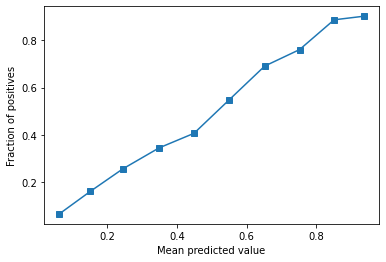

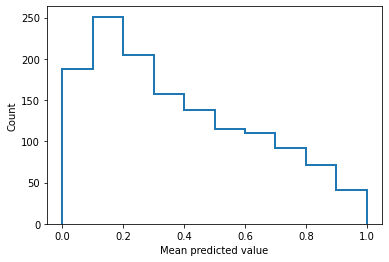

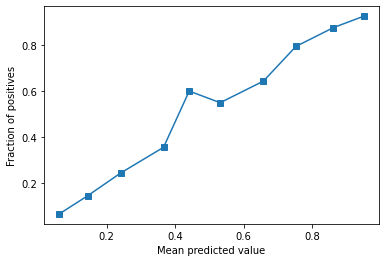

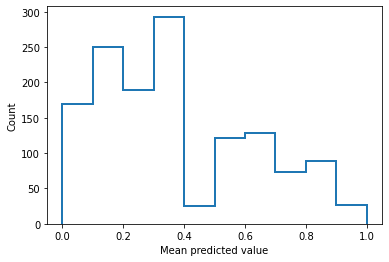

ROC AUC: 0.8095044991980281
Average Precision: 0.7386963052733777
Accuracy: 0.7556693489392831
ROC AUC: 0.8101546854186112
Average Precision: 0.7256683461787354
Accuracy: 0.7505486466715435

| Step 2 ==> Calculate SHAP values
Kernel Explainer Iteration 0


  0%|          | 0/2188 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

explainer = medical_explainer.explainer(
    pipe, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='kernel', method='novel', n_splits=2)

In [64]:
import shap

exp = shap.KernelExplainer(explainer.calibrated_clf.calibrated_classifiers_[0].base_estimator.predict, explainer.X_train[:50].values)
shap_values = exp.shap_values(explainer.X_train[50:150].values, nsamples=500)

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
from scipy.special import expit, logit

# expit(shap_values)
shap_values_post = shap_values[1] + exp.expected_value[1]


In [65]:
shap_values + exp.expected_value

array([[0.40732595, 0.32      , 0.33842447, ..., 0.32      , 0.37698829,
        0.29111798],
       [0.3315708 , 0.30659646, 0.32233645, ..., 0.34439353, 0.60013634,
        0.27555019],
       [0.35638041, 0.32      , 0.34009065, ..., 0.31224606, 0.14884684,
        0.27354219],
       ...,
       [0.31327624, 0.32      , 0.33652029, ..., 0.31658158, 0.28274613,
        0.30422092],
       [0.55137981, 0.32      , 0.37386189, ..., 0.25771417, 0.6095923 ,
        0.25248529],
       [0.32514514, 0.31776737, 0.33150568, ..., 0.31979453, 0.28289421,
        0.29684454]])

In [12]:
explainer.variables

array(['LOS', 'RDW', 'ICU_LOS', 'Age', 'inotropes',
       'Lactate Dehydrogenase (LD)', 'Haptoglobin', 'Phosphate', 'ICUs',
       'Albumin'], dtype=object)

In [13]:
explainer.score_array_list

[array([ 8., -5.]),
 array([-3.,  4.]),
 array([ 1., -2.,  4.]),
 array([-2.,  3.]),
 array([-3.,  2.]),
 array([-2.,  1.]),
 array([ 2., -1.]),
 array([-1.,  1.]),
 array([ 0., -1.,  4.]),
 array([ 1., -1.])]

In [14]:
explainer.breakpoints_list

[[-0.3222222222222222, 8.420296637338277, 294.66041666666666],
 [11.6, 15.442368481276056, 30.5],
 [0.008, 0.043143496038710594, 5.281013550406813, 153.928],
 [18.258726899383984, 73.08052113237441, 90.0],
 [0.0, 0.9401474154387959, 3.0],
 [-8.271937990619335, 207.60238455174488, 23111.0],
 [-151.44629140606094, 158.81343669848746, 688.0],
 [0.2, 3.4487048423198887, 17.3],
 [0.0, 0.26254122009811004, 1.121022950650504, 5.0],
 [0.0, 2.7469765455333497, 18.290282613036652]]

In [15]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.7432410084003154
Average Precision: 0.6392679031444433
Accuracy: 0.695683979517191
[[772  72]
 [344 179]]


In [25]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [30]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.7469063456868335, 0.7376555577417688, 0.7561571336318981)
(0.6471622941122264, 0.6342367766283696, 0.6600878115960831)
(0.6975999999999999, 0.6902457637156658, 0.704954236284334)
